# Evaluation Pipeline for Synthetic Time Series Data

##### Author: Tim Seidel 

The following code serves as reference for the Bachelor Thesis. It is a pipeline that aims to assist in the evaluation of the quality of the synthetic time series datasets that were generated during the course of the Bachelor Thesis. Hence, it employs the following evaluation approaches and metrics: 
1. Visual Assessments (overlayed & separate)
2. Descriptive Statistics including boxplots
3. Correlation (only for multivariate Datasets)
4. Wasserstein Distance
5. Jensen-Shannon Distance
6. Kolmogorov-Smirnov Test
7. Marginal Distributional Difference (including KDE comparisons)
8. Autocorrelation Difference
9. Skewness Difference
10. Kurtosis Difference
11. Autocorrelation Plotted

In [124]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import acf
from scipy.spatial.distance import jensenshannon
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import seaborn as sns
import torch
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.stats import wasserstein_distance
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde

### Load Data and Reformat Accordingly

In [344]:
# Load data into dataframes
df_real = pd.read_csv("df_esa_NoAnomalies.csv") 
df_synth = pd.read_csv("synth_NoAnomalies_25415359_6450_v2.csv")

In [345]:
# Only execute this cell when using TimeVQVAE
num_rows = df_synth.shape[0]
# Create a range of timestamps
start_datetime = datetime(2000, 1, 1, 0, 0, 0)
datetimes = [start_datetime + timedelta(seconds=30 * i) for i in range(num_rows)]

df_synth['timestamp'] = datetimes

#df_synth.rename(columns={
#    'Column_0': 'channel_25',
#    'Column_1': 'channel_41',
#    'Column_0': 'channel_53',
#    'Column_1': 'channel_59',
#}, inplace=True)

df_synth = df_synth[['timestamp', "channel_25","channel_41", "channel_53", "channel_59"]]
df_synth

,timestamp,channel_25,channel_41,channel_53,channel_59
0,2000-01-01 00:00:00,0.289165,0.815926,0.858164,0.890155
1,2000-01-01 00:00:30,0.289116,0.812760,0.861935,0.890114
2,2000-01-01 00:01:00,0.289064,0.812671,0.721723,0.890103
3,2000-01-01 00:01:30,0.289045,0.812609,0.721518,0.890169
4,2000-01-01 00:02:00,0.288948,0.811086,0.860068,0.890377
...,...,...,...,...,...
6445,2000-01-03 05:42:30,0.287800,0.814272,0.868281,0.890079
6446,2000-01-03 05:43:00,0.287807,0.816571,1.002598,0.890095
6447,2000-01-03 05:43:30,0.287822,0.817378,0.853353,0.890146
6448,2000-01-03 05:44:00,0.287812,0.815808,0.851687,0.890181


In [346]:
COLUMNS_Sinusoidal = ["channel_25", "channel_27"] #2900, 5000 epochs
#COLUMNS_Sinusoidal = ["channel_25"]
COLUMNS_Cluster4 = ["channel_15", "channel_23"]
COLUMNS_Cluster3 = ["channel_14", "channel_21"]
COLUMNS_MinVVariance = ["channel_14", "channel_15", "channel_16", "channel_21", "channel_22", "channel_23", "channel_24", "channel_29", "channel_30", "channel_32", "channel_33", "channel_38", "channel_39", "channel_40", "channel_41", "channel_42", "channel_43", "channel_44", "channel_45", "channel_46", "channel_50", "channel_51", "channel_52", "channel_58", "channel_59", "channel_60", "channel_70", "channel_71", "channel_72", "channel_73", "channel_74", "channel_75", "channel_76"]
COLUMNS_MaxVariance = ["channel_53", "channel_54", "channel_55", "channel_56"]
COLUMNS_Steps = ["channel_61", "channel_62", "channel_63"]

COLUMNS_Cluster5 = ["channel_33", "channel_40"]
COLUMNS_Cluster6 = ["channel_41", "channel_42", "channel_43", "channel_44", "channel_45", "channel_46", "channel_70", "channel_71", "channel_72", "channel_73", "channel_74", "channel_75", "channel_76"]
COLUMNS_Cluster7 = ["channel_47", "channel_49"]
COLUMNS_Cluster8 = ["channel_53","channel_54"]
COLUMNS_Cluster9 = ["channel_57","channel_59"]
COLUMNS_Cluster10 = ["channel_62", "channel_63"]
COLUMNS_Cluster11 = ["channel_64", "channel_65", "channel_69"]
COLUMNS_Cluster12 = ["channel_66"]
COLUMNS_Cluster13 = ["channel_67", "COLUMNS_Cluster10"]

COLUMNS_1st4Clusters = ["channel_15","channel_19", "channel_41", "channel_61"]
COLUMNS_Multivariate = ["channel_25", "channel_41", "channel_53", "channel_59"]

df_original = df_real[["timestamp"] + COLUMNS_Multivariate]
df_original = df_original.dropna()
num_rows = df_original.shape[0]
start_datetime = datetime(2000, 1, 1, 0, 0, 0)
datetimes = [start_datetime + timedelta(seconds=30 * i) for i in range(num_rows)]
df_original["timestamp"] = datetimes

In [347]:
df_original = df_original.iloc[:df_synth.shape[0]]
df_original

,timestamp,channel_25,channel_41,channel_53,channel_59
0,2000-01-01 00:00:00,0.289167,0.812578,0.858232,0.890102
1,2000-01-01 00:00:30,0.289167,0.812578,0.858232,0.890102
2,2000-01-01 00:01:00,0.289167,0.821213,0.571646,0.890102
3,2000-01-01 00:01:30,0.289167,0.819642,0.858232,0.890102
4,2000-01-01 00:02:00,0.289167,0.821996,0.858232,0.890102
...,...,...,...,...,...
6445,2000-01-03 05:42:30,0.287660,0.806299,1.000000,0.890102
6446,2000-01-03 05:43:00,0.287660,0.807868,0.858232,0.890102
6447,2000-01-03 05:43:30,0.287660,0.806299,0.858232,0.890102
6448,2000-01-03 05:44:00,0.287660,0.807868,0.858232,0.890102


### 1. Visual Assessment
This section aims to provide a means to assess the synthetic series visually. Therefore, each pair of features (synthetic & real) will be plotted. 

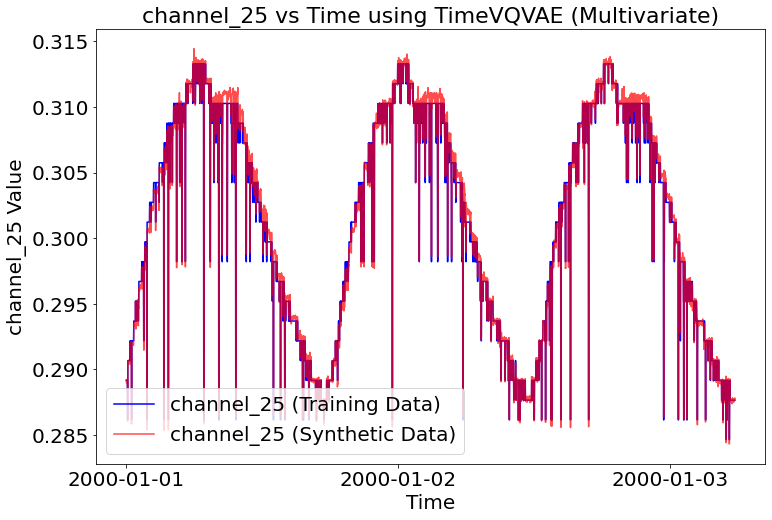

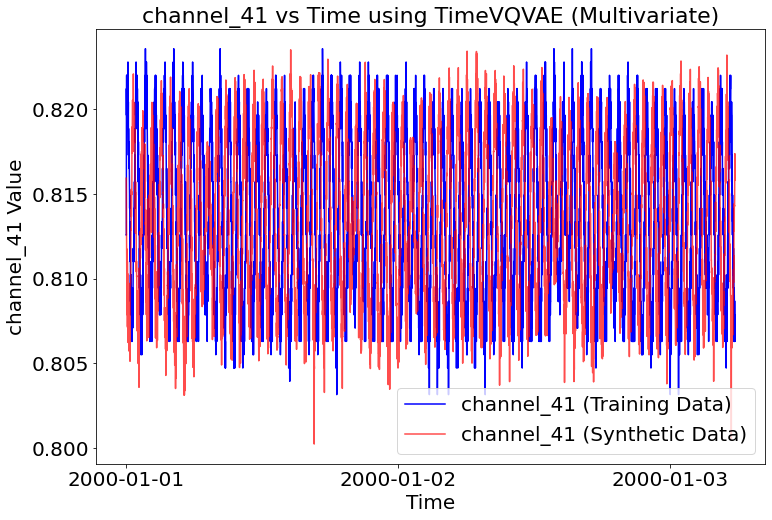

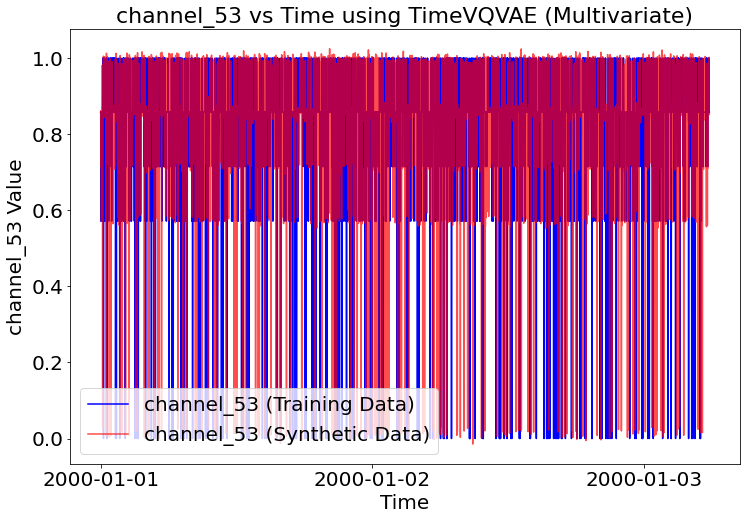

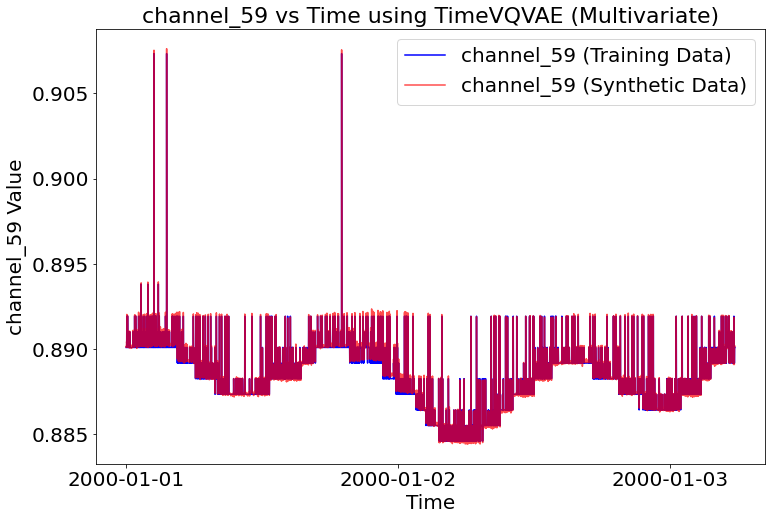

In [348]:
df_first_N_training = df_original.iloc[:6450].copy()
df_first_N_synthetic = df_synth.iloc[:6450].copy()

# Convert 'timestamp' columns to datetime format
df_first_N_training['timestamp'] = pd.to_datetime(df_first_N_training['timestamp'])
df_first_N_synthetic['timestamp'] = pd.to_datetime(df_first_N_synthetic['timestamp'])

# Generate ticks manually
tick_indices = df_first_N_training['timestamp'].dt.floor('D').drop_duplicates().index
tick_labels = df_first_N_training['timestamp'].dt.strftime('%Y-%m-%d').iloc[tick_indices]

plt.rcParams.update({
    'font.size': 18,        
    'axes.titlesize': 22,
    'axes.labelsize': 20,   
    'xtick.labelsize': 20,  
    'ytick.labelsize': 20, 
    'legend.fontsize': 20   
})

# Iterate over each column and plot it against time
for column in df_first_N_training.columns:
    if column != 'timestamp':
        plt.figure(figsize=(12, 8))
        
        plt.plot(df_first_N_training['timestamp'], df_first_N_training[column], 
                 label=f'{column} (Training Data)', color='blue')
        plt.plot(df_first_N_synthetic['timestamp'], df_first_N_synthetic[column], 
                 label=f'{column} (Synthetic Data)', color='red', alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel(f'{column} Value')
        plt.title(f'{column} vs Time using TimeVQVAE (Multivariate)')
        plt.legend()

        plt.xticks(ticks=df_first_N_training['timestamp'].iloc[tick_indices], labels=tick_labels, rotation=0)
        # plt.savefig(f'No_Anomalies_TrainAndSynth/{column}_vs_time.png')
        plt.show()


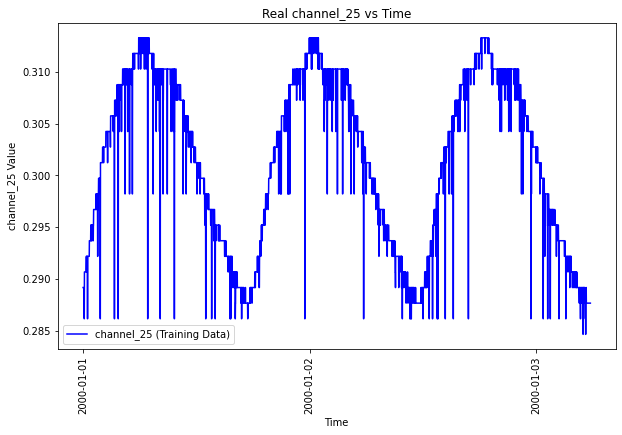

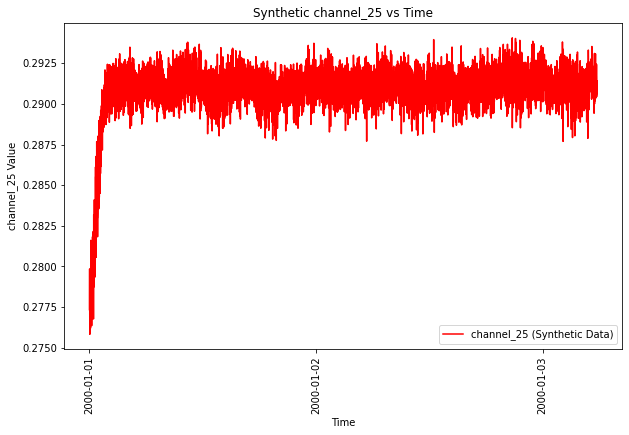

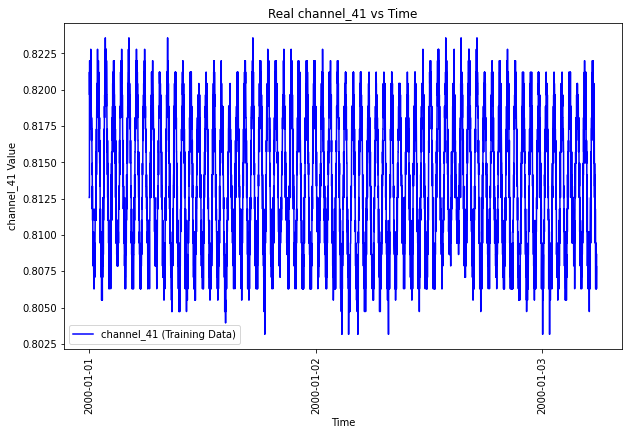

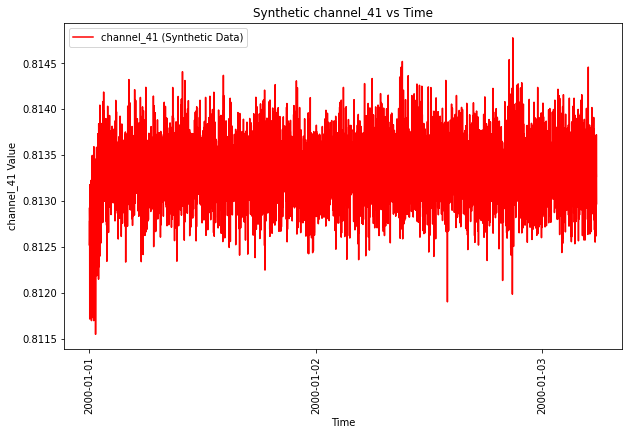

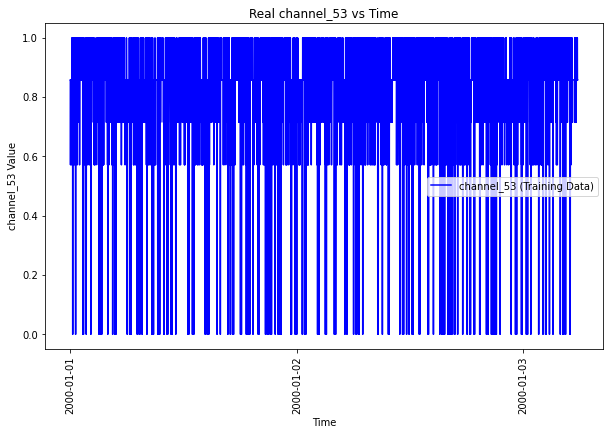

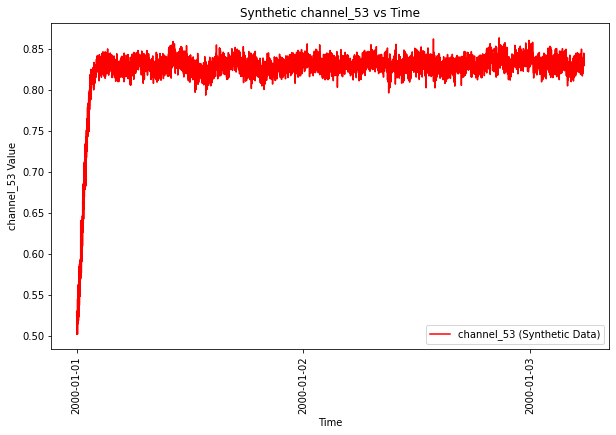

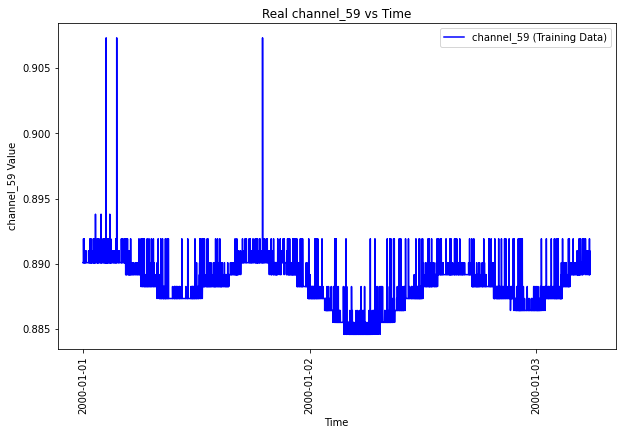

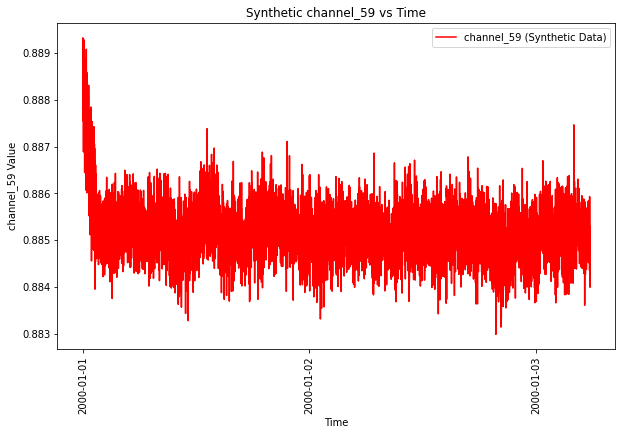

In [141]:
df_first_N_training = df_original.iloc[:6450].copy()
df_first_N_synthetic = df_synth.iloc[:6450].copy()

# Convert 'timestamp' columns to datetime format
df_first_N_training['timestamp'] = pd.to_datetime(df_first_N_training['timestamp'])
df_first_N_synthetic['timestamp'] = pd.to_datetime(df_first_N_synthetic['timestamp'])

# Generate ticks manually
tick_indices = df_first_N_training['timestamp'].dt.floor('D').drop_duplicates().index
tick_labels = df_first_N_training['timestamp'].dt.strftime('%Y-%m-%d').iloc[tick_indices]

# Iterate over each column and plot it against time
for column in df_first_N_training.columns:
    if column != 'timestamp':
        plt.figure(figsize=(10, 6))
        plt.plot(df_first_N_training['timestamp'], df_first_N_training[column], 
                 label=f'{column} (Training Data)', color='blue')
        plt.xlabel('Time')
        plt.ylabel(f'{column} Value')
        plt.title(f'Real {column} vs Time')
        plt.legend()
        plt.xticks(ticks=df_first_N_training['timestamp'].iloc[tick_indices], labels=tick_labels, rotation=90)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df_first_N_synthetic['timestamp'], df_first_N_synthetic[column], 
                 label=f'{column} (Synthetic Data)', color='red')
        plt.xlabel('Time')
        plt.ylabel(f'{column} Value')
        plt.title(f'Synthetic {column} vs Time')
        plt.legend()
        plt.xticks(ticks=df_first_N_training['timestamp'].iloc[tick_indices], labels=tick_labels, rotation=90)
        plt.show()

### 2. Descriptive Statistics

In [142]:
numerical_features_original = df_original.select_dtypes(include=[np.number]).columns.tolist()
numerical_features_synthetic = df_synth.select_dtypes(include=[np.number]).columns.tolist()

df_original_filtered = df_original[numerical_features_original]
df_synth_filtered = df_synth[numerical_features_synthetic]

# Compute descriptive statistics
desc_stats_original = df_original_filtered.describe()
desc_stats_synthetic = df_synth_filtered.describe()

print("Descriptive Statistics for Original Data (excluding 'timestamp'):\n", desc_stats_original)
print("Descriptive Statistics for Synthetic Data (excluding 'timestamp'):\n", desc_stats_synthetic)

Descriptive Statistics for Original Data (excluding 'timestamp'):
         channel_25   channel_41   channel_53   channel_59
count  6450.000000  6450.000000  6450.000000  6450.000000
mean      0.301530     0.813631     0.837404     0.888295
std       0.008313     0.004756     0.158561     0.001729
min       0.284645     0.803160     0.000000     0.884607
25%       0.293690     0.809439     0.858232     0.887354
50%       0.302735     0.813363     0.858232     0.888272
75%       0.310275     0.818072     0.858232     0.889185
max       0.313290     0.823567     1.000000     0.907327
Descriptive Statistics for Synthetic Data (excluding 'timestamp'):
         channel_25   channel_41   channel_53   channel_59
count  6450.000000  6450.000000  6450.000000  6450.000000
mean      0.290871     0.813334     0.825511     0.885193
std       0.001685     0.000342     0.032902     0.000605
min       0.275826     0.811546     0.501902     0.882987
25%       0.290405     0.813115     0.823787     0.88

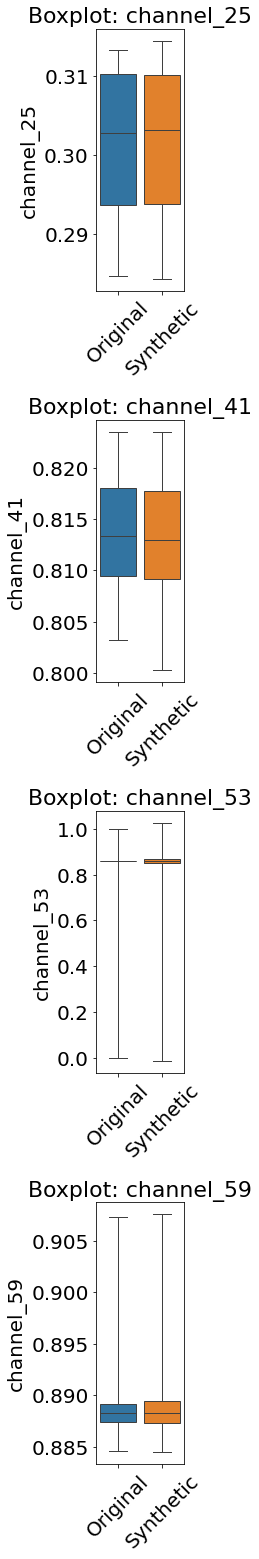

In [358]:
columns = df_original_filtered.columns
plt.figure(figsize=(3,22)) 

# Loop through each column to create side-by-side boxplots
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    
    data = pd.DataFrame({
        'Original': df_original_filtered[column],
        'Synthetic': df_synth_filtered[column]
    })

    # Create the boxplot for the current column
    sns.boxplot(data=data, whis=(0, 100))
    plt.title(f'Boxplot: {column}')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 3. Correlation Matrices

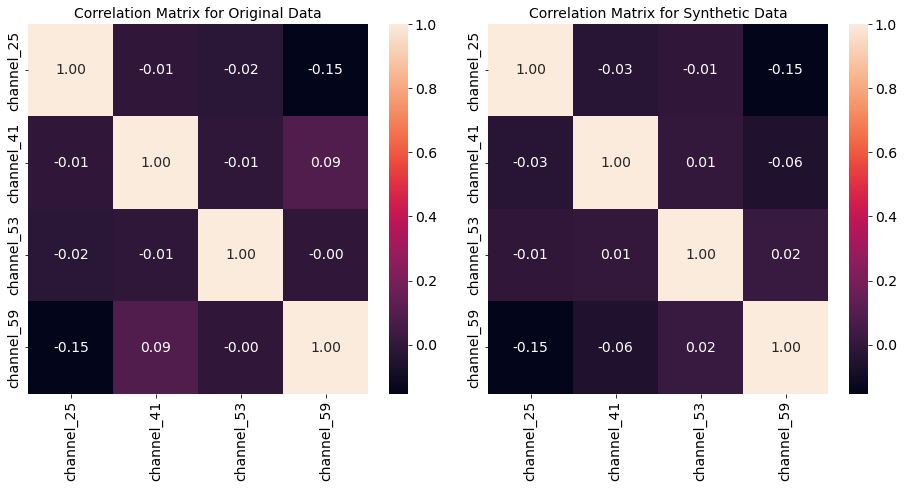

In [349]:
numerical_features_original = df_original.select_dtypes(include=[np.number]).columns.tolist()
numerical_features_synthetic = df_synth.select_dtypes(include=[np.number]).columns.tolist()

df_original_filtered = df_original[numerical_features_original]
df_synth_filtered = df_synth[numerical_features_synthetic]

# Compute correlation matrices
corr_original = df_original_filtered.corr()
corr_synthetic = df_synth_filtered.corr()

# Compute the range for color scaling
min_corr = min(corr_original.min().min(), corr_synthetic.min().min())
max_corr = max(corr_original.max().max(), corr_synthetic.max().max())

plt.rcParams.update({
    'font.size': 14,        
    'axes.titlesize': 14,   
    'axes.labelsize': 14,   
    'xtick.labelsize': 14,  
    'ytick.labelsize': 14,    
})

plt.figure(figsize=(13, 7))

# Heatmap for the original data
plt.subplot(1, 2, 1)
sns.heatmap(corr_original, annot=True, vmin=min_corr, vmax=max_corr, fmt=".2f")
plt.title('Correlation Matrix for Original Data')

# Heatmap for the synthetic data
plt.subplot(1, 2, 2)
sns.heatmap(corr_synthetic, annot=True, vmin=min_corr, vmax=max_corr, fmt=".2f")
plt.title('Correlation Matrix for Synthetic Data')

plt.tight_layout()
plt.show()

### 4. Wasserstein Distance

Wasserstein Distance (WD) for each feature:
{'channel_25': 0.00015976581261059023, 'channel_41': 5.1532307144012915e-05, 'channel_53': 0.000889781574946392, 'channel_59': 9.329453126479489e-06}


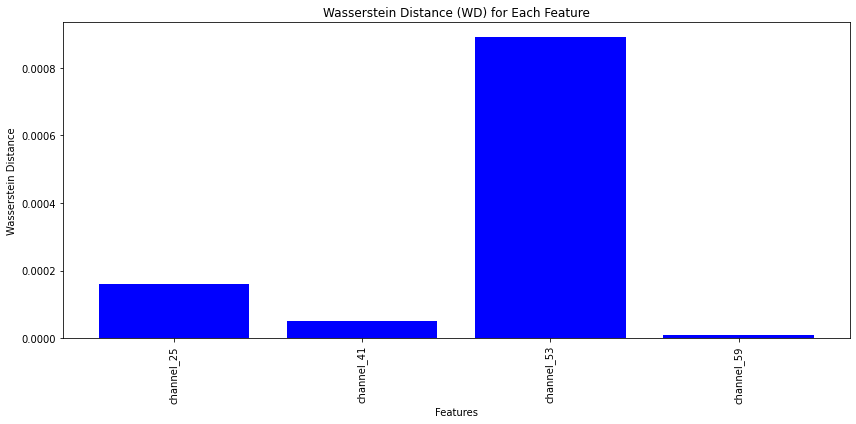

In [145]:
def compute_average_wasserstein_distance(df_real, df_synth, max_freq=1000):
    aws_values = {}
    
    numerical_features = df_real.select_dtypes(include=[np.number]).columns.tolist()
    
    for feature in numerical_features:
        real_values = df_real[feature].dropna().values
        synth_values = df_synth[feature].dropna().values
        
        # Apply FFT and compute amplitude spectra
        fft_real = np.abs(fft(real_values))[:max_freq]
        fft_synth = np.abs(fft(synth_values))[:max_freq]
        
        # Normalize the amplitude spectra
        fft_real /= np.sum(fft_real)
        fft_synth /= np.sum(fft_synth)
        
        # Compute Wasserstein Distance
        wd = wasserstein_distance(fft_real, fft_synth)
        aws_values[feature] = wd
    
    return aws_values

aws_values = compute_average_wasserstein_distance(df_original, df_synth)

print("Wasserstein Distance (WD) for each feature:")
print(aws_values)

plt.figure(figsize=(12, 6))
plt.bar(aws_values.keys(), aws_values.values(), color='blue')
plt.title('Wasserstein Distance (WD) for Each Feature')
plt.xlabel('Features')
plt.ylabel('Wasserstein Distance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 5. Compute Jensen-Shannon Distance

Jensen-Shannon Distance (Histogram):
 {'channel_25': 0.5783484020760477, 'channel_41': 0.47961755325682154, 'channel_53': 0.7652899332903556, 'channel_59': 0.6674571089647934}


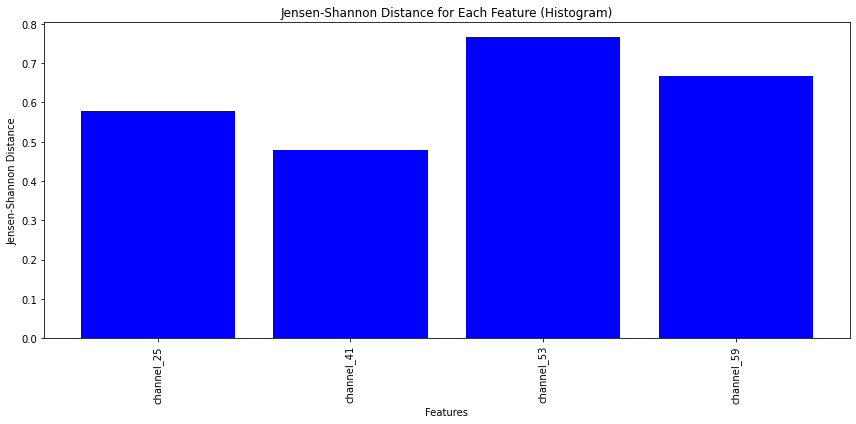

In [146]:
def get_histogram_distribution(df, col, bins=30):
    hist, bin_edges = np.histogram(df[col].dropna(), bins=bins, density=True)
    hist += 1e-10  # Avoid zero probabilities for numerical stability
    return hist, bin_edges

# Jensen-Shannon Distance Calculation
def calculate_jsd_hist(df1, df2, col, bins=30):
    hist1, bin_edges = get_histogram_distribution(df1, col, bins)
    hist2, _ = get_histogram_distribution(df2, col, bins)
    
    # Normalize histograms
    hist1 /= hist1.sum()
    hist2 /= hist2.sum()
    
    # Compute JS Distance
    jsd = jensenshannon(hist1, hist2)
    return jsd

# Compute JSD for each column using histograms
jsd_hist = {col: calculate_jsd_hist(df_original, df_synth, col) for col in df_original.columns if col != 'timestamp'}
print("Jensen-Shannon Distance (Histogram):\n", jsd_hist)


# Plotting JSDs
def plot_jsd(jsd_dict, title):
    feature_names = list(jsd_dict.keys())
    js_values = list(jsd_dict.values())

    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, js_values, color='blue')
    plt.xlabel('Features')
    plt.ylabel('Jensen-Shannon Distance')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    #plt.savefig("Evaluation_Images/JSDistance_KDE_2527_DGAN")
    plt.show()

plot_jsd(jsd_hist, 'Jensen-Shannon Distance for Each Feature (Histogram)')

### 6. Kolmogrov Smirnov Metric

In [147]:
numerical_features = df_original.select_dtypes(include=[np.number]).columns.tolist()

# Perform KS Test for each numerical feature
ks_test_results = {}
for col in numerical_features:
    ks_statistic, ks_p_value = stats.ks_2samp(df_original[col].dropna(), df_synth[col].dropna())
    ks_test_results[col] = {'KS Statistic': ks_statistic, 'P-value': ks_p_value}

print("KS Test Results:\n")
for feature, result in ks_test_results.items():
    print(f"{feature}:\n  KS Statistic: {result['KS Statistic']}\n  P-value: {result['P-value']}\n")

KS Test Results:

channel_25:
  KS Statistic: 0.7784496124031007
  P-value: 0.0

channel_41:
  KS Statistic: 0.4731782945736434
  P-value: 0.0

channel_53:
  KS Statistic: 0.8866666666666667
  P-value: 0.0

channel_59:
  KS Statistic: 0.8745736434108528
  P-value: 0.0



### 7. Compute Marginal Distribution Difference

Feature: channel_25
MDD: 1.3151544042125027



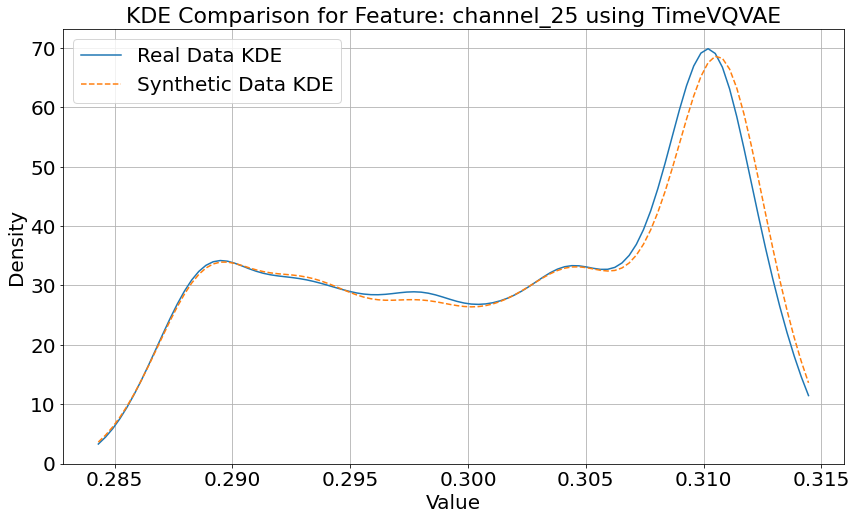

Feature: channel_41
MDD: 3.7308473103782114



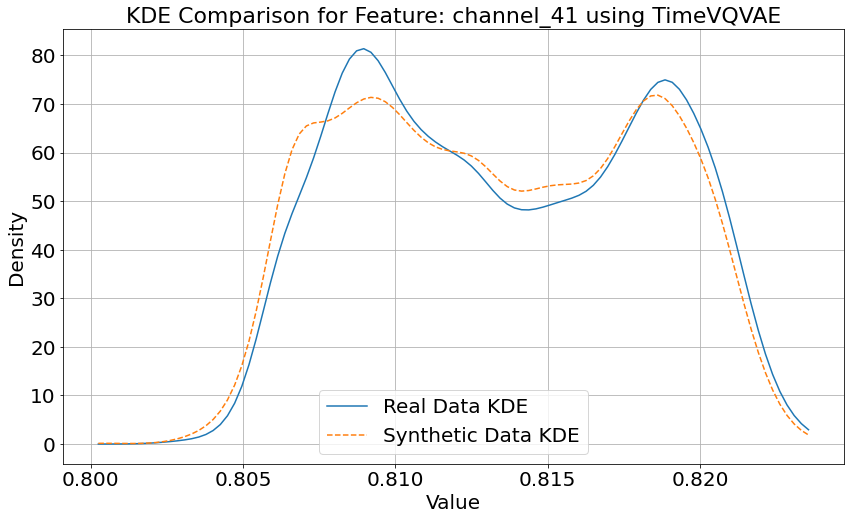

Feature: channel_53
MDD: 0.06010083156587064



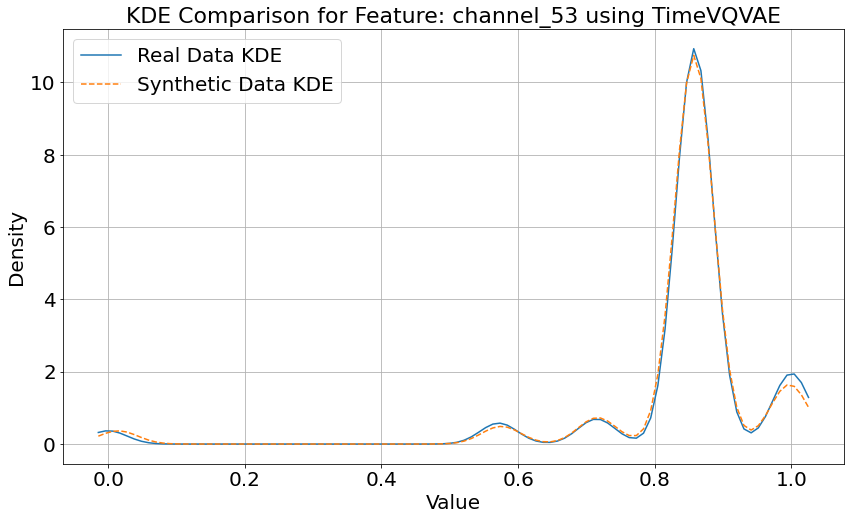

Feature: channel_59
MDD: 3.5686379247024007



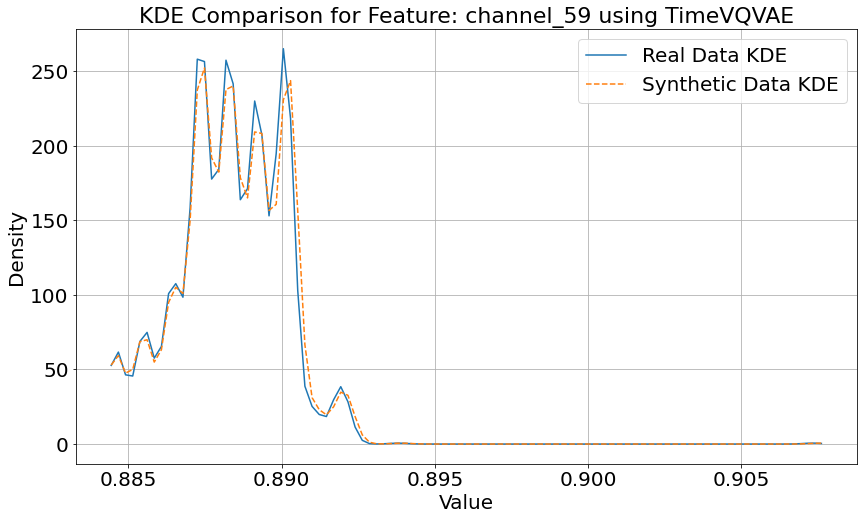

Feature-wise MDD values:
channel_25: 1.3151544042125027
channel_41: 3.7308473103782114
channel_53: 0.06010083156587064
channel_59: 3.5686379247024007


In [350]:
def marginal_distribution_difference(real, generated):
    
    #Calculates the Marginal Distribution Difference (MDD) between real and generated data using KDE.
    real_values = real.flatten()
    generated_values = generated.flatten()
    
    # Create KDE objects for real and generated data
    real_kde = gaussian_kde(real_values)
    gen_kde = gaussian_kde(generated_values)
    
    # Create a range of x values to evaluate the KDEs
    x = np.linspace(min(real_values.min(), generated_values.min()), 
                    max(real_values.max(), generated_values.max()), 100)
    
    # Calculate KDE values for both real and generated data
    real_kde_values = real_kde(x)
    gen_kde_values = gen_kde(x)
    
    # Compute the average absolute difference between the KDEs
    mdd = np.mean(np.abs(real_kde_values - gen_kde_values))
    return mdd, x, real_kde_values, gen_kde_values

def compute_kde_marginal_distribution_difference(df_real, df_synth):
    feature_names = []
    mdd_values = []
    
    numerical_features = df_real.select_dtypes(include=[np.number]).columns.tolist()
    
    for feature in numerical_features:

        real_feature = df_real[feature].dropna().values
        synth_feature = df_synth[feature].dropna().values
        
        # Calculate MDD
        mdd, x, real_kde_values, gen_kde_values = marginal_distribution_difference(real_feature, synth_feature)
        
        feature_names.append(feature)
        mdd_values.append(mdd)

        print(f"Feature: {feature}")
        print(f"MDD: {mdd}\n")
        
        plt.rcParams.update({
            'font.size': 18,        
            'axes.titlesize': 22,   
            'axes.labelsize': 20,   
            'xtick.labelsize': 20,  
            'ytick.labelsize': 20,  
            'legend.fontsize': 20  
        })
        
        plt.figure(figsize=(14, 8))
        plt.plot(x, real_kde_values, label='Real Data KDE')
        plt.plot(x, gen_kde_values, label='Synthetic Data KDE', linestyle='--')
        plt.title(f"KDE Comparison for Feature: {feature} using TimeVQVAE")
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return feature_names, mdd_values

feature_names, mdd_values = compute_kde_marginal_distribution_difference(df_original, df_synth)

print("Feature-wise MDD values:")
for feature, mdd in zip(feature_names, mdd_values):
    print(f"{feature}: {mdd}")


### 8. Compute Autocorrelation Difference

{'channel_25': 0.11678298028035883, 'channel_41': 0.1386917172071114, 'channel_53': 0.006617189936793655, 'channel_59': 0.050138204222651646}


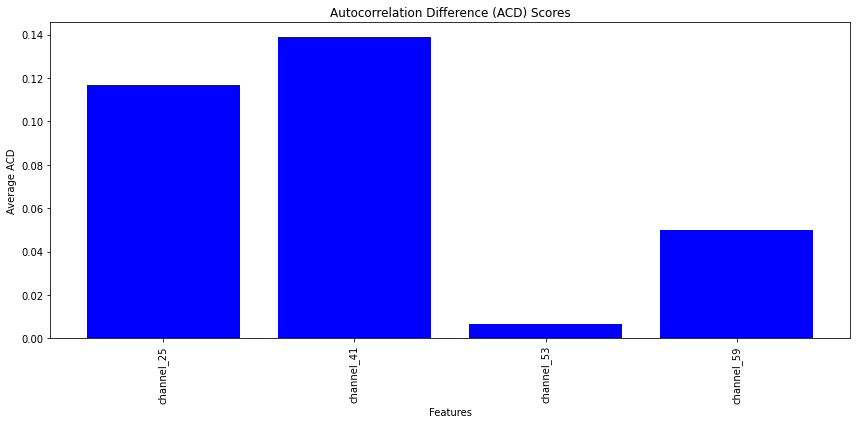

In [149]:
def compute_autocorrelation_difference(df_real, df_synth, max_lag=6450):
    acd_values = {}
    
    numerical_features = df_real.select_dtypes(include=[np.number]).columns.tolist()
    
    for feature in numerical_features:
        real_values = df_real[feature].dropna()
        synth_values = df_synth[feature].dropna()
        
        # Compute autocorrelation for a range of lags
        ac_real = acf(real_values, nlags=max_lag, fft=True)
        ac_synth = acf(synth_values, nlags=max_lag, fft=True)
        
        # Compute MSE
        mse = mean_squared_error(ac_real, ac_synth)
        acd_values[feature] = mse
    
    return acd_values

acd_values = compute_autocorrelation_difference(df_original, df_synth)
print(acd_values)

# Plotting ACD scores
plt.figure(figsize=(12, 6))
plt.bar(acd_values.keys(), acd_values.values(), color='blue')
plt.title('Autocorrelation Difference (ACD) Scores')
plt.xlabel('Features')
plt.ylabel('Average ACD')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Evaluation_Images/AutoCorrDiff_2527_DGAN")
plt.show()

### 9. Compute Skewness Difference

{'channel_25': 4.162515984499659, 'channel_41': 0.2318947085810416, 'channel_53': 3.038849454545481, 'channel_59': 0.5868284852563241}


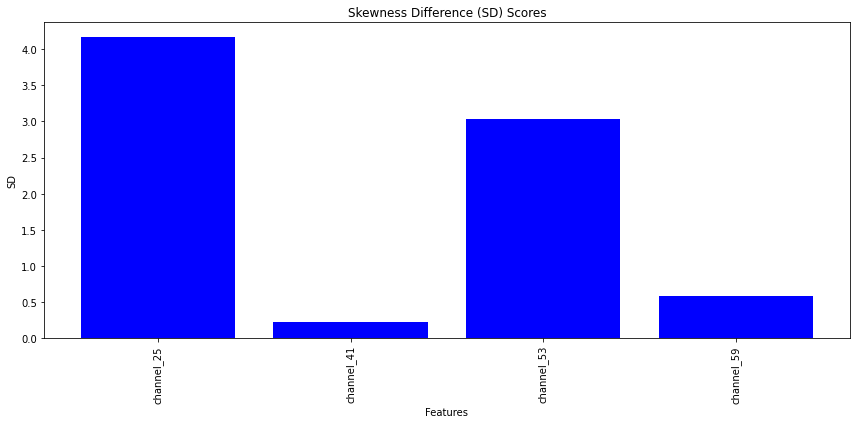

In [150]:
def compute_skewness_difference(df_real, df_synth):
    sd_values = {}
    
    numerical_features = df_real.select_dtypes(include=[np.number]).columns.tolist()
    
    for feature in numerical_features:
        skew_real = skew(df_real[feature])
        skew_synth = skew(df_synth[feature])
        
        sd = np.abs(skew_real - skew_synth)
        sd_values[feature] = sd
    
    return sd_values

sd_real = compute_skewness_difference(df_original, df_synth)
print(sd_real)

plt.figure(figsize=(12, 6))
plt.bar(sd_real.keys(), sd_real.values(), color='blue')
plt.title('Skewness Difference (SD) Scores')
plt.xlabel('Features')
plt.ylabel('SD')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Evaluation_Images/Skewness_2527_DGAN")
plt.show()

### 10. Compute Kurtosis Difference

{'channel_25': 30.414616498716235, 'channel_41': 1.9717444639193267, 'channel_53': 34.77076001010931, 'channel_59': 1.8957331841322418}


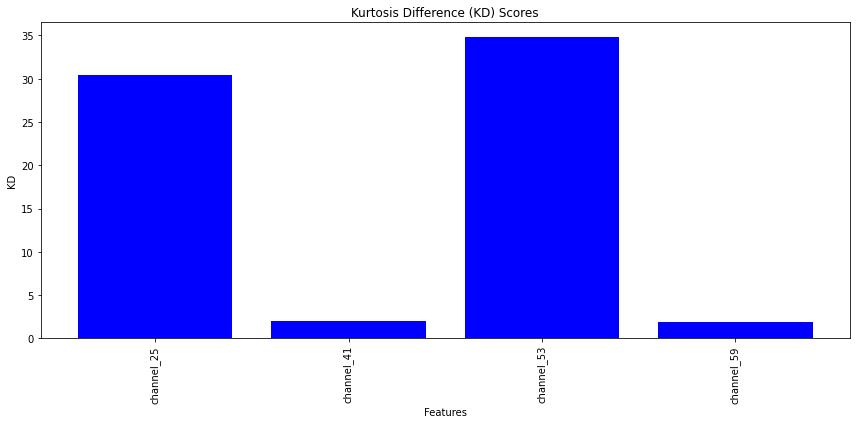

In [151]:
def compute_kurtosis_difference(df_real, df_synth):
    kd_values = {}
    
    numerical_features = df_real.select_dtypes(include=[np.number]).columns.tolist()
    
    for feature in numerical_features:
        kurt_real = kurtosis(df_real[feature])
        kurt_synth = kurtosis(df_synth[feature])
        
        kd = np.abs(kurt_real - kurt_synth)
        kd_values[feature] = kd
    
    return kd_values

kd_real = compute_kurtosis_difference(df_original, df_synth)
print(kd_real)

plt.figure(figsize=(12, 6))
plt.bar(kd_real.keys(), kd_real.values(), color='blue')
plt.title('Kurtosis Difference (KD) Scores')
plt.xlabel('Features')
plt.ylabel('KD')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Evaluation_Images/Kurtosis_2527_DGAN")
plt.show()

### 11. Autocorrelation Plotted

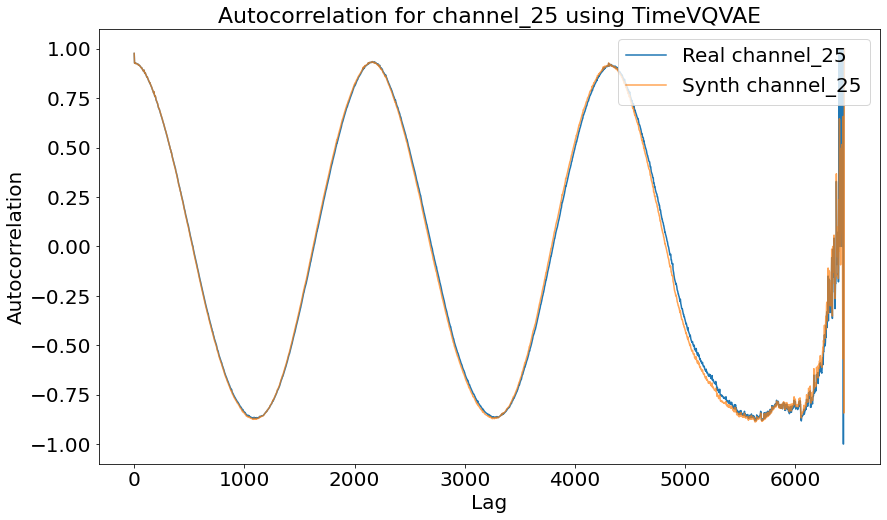

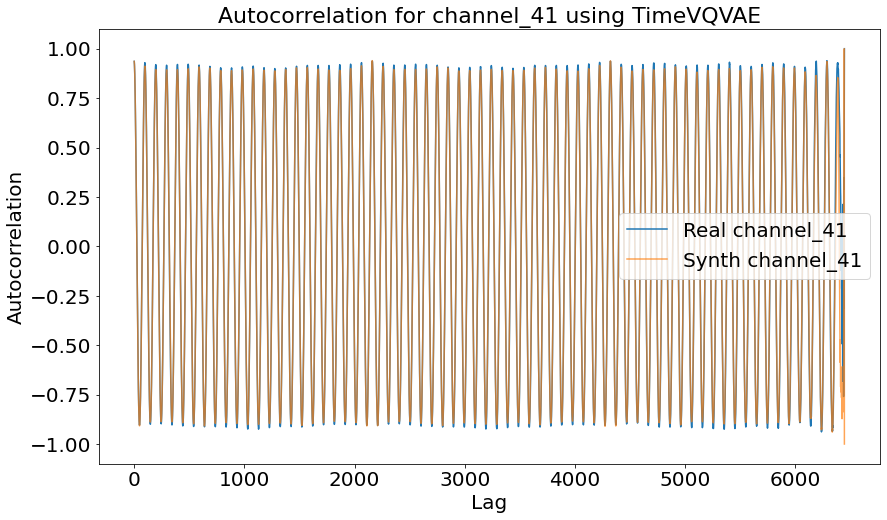

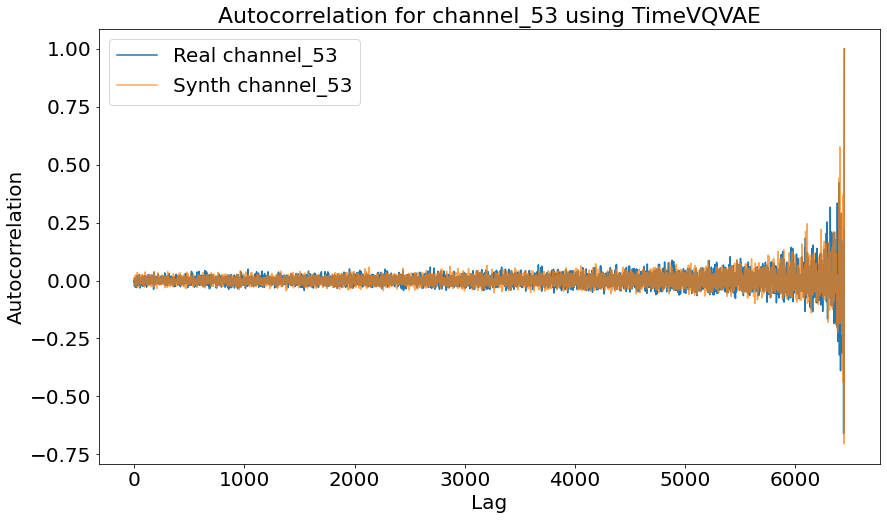

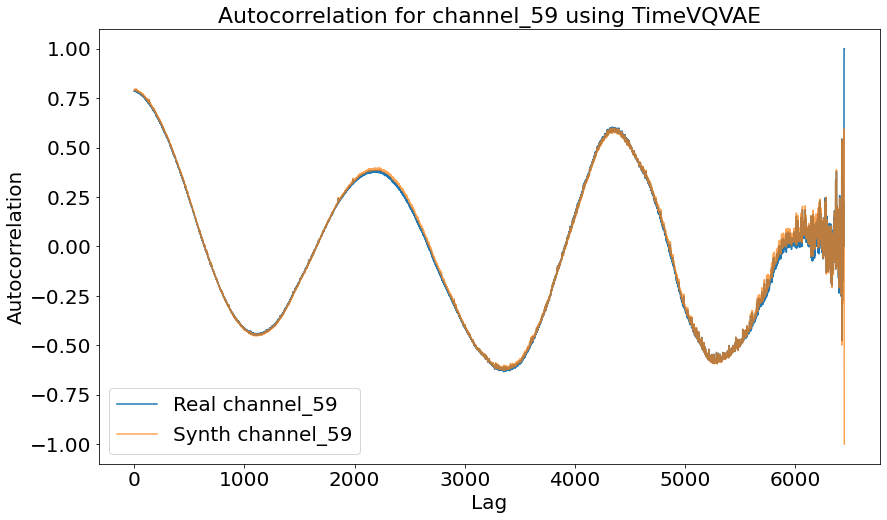

In [351]:
EPS = 1e-8

def autocorr(X, Y):
    X = X.float()
    Y = Y.float()
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0  # 1 is a perfect positive relationship
    r[r < -1] = 0  # -1 is a perfect negative relationship

    return r

# Input: one feature (timeseries) as a numpy array
# Output: Autocorrelation vector
def get_autocorr(feature):
    feature = torch.from_numpy(feature).float()
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
        autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j], feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

# Function to compute autocorrelation for each column in the dataframe
def compute_autocorrelation(df):
    autocorr_results = {}
    for col in df.columns:
        if df[col].dtype != object and df[col].dtype != np.datetime64 and col != 'timestamp':
            feature = df[col].values.reshape(1, -1)
            autocorr_results[col] = get_autocorr(feature)
    return autocorr_results

df_real = df_original.copy()
df_synthetic = df_synth.copy()

df_real = df_real.iloc[:6450 ]
df_synthetic = df_synthetic.iloc[:6450 ]

autocorr_real = compute_autocorrelation(df_real)
autocorr_synth = compute_autocorrelation(df_synthetic)

plt.rcParams.update({
    'font.size': 18,        
    'axes.titlesize': 22,   
    'axes.labelsize': 20,  
    'xtick.labelsize': 20,  
    'ytick.labelsize': 20,  
    'legend.fontsize': 20   
})

for col in autocorr_real:
    plt.figure(figsize=(14, 8))
    plt.plot(autocorr_real[col], label=f'Real {col}')
    plt.plot(autocorr_synth[col], label=f'Synth {col}', alpha=0.7)
    plt.title(f'Autocorrelation for {col} using TimeVQVAE')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.legend()
    #plt.savefig(f"Evaluation_Images/AutoCorrPlot_{col}")
    plt.show()